In [1]:
import kagglehub
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# Final Dataset source from: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset?select=phishing_email.csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv('/content/drive/MyDrive/ECE 597 Capstone/phishing_email.csv')

In [4]:
data.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [5]:
data['text'] = data['text_combined']
data = data.drop(columns=['text_combined'])
data['text'] = data['text'].str.lower()

# Clean URLs special characters
def clean_text(text):
    text = re.sub(r'\S+@\S+', ' ', text)  # remove email addresses
    text = re.sub(r'http\S+|www\S+', ' ', text)  # remove URLs
    text = re.sub(r'\d+', ' ', text)  # remove numbers
    text = re.sub(r'[^\w\s]', ' ', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    text = re.sub(r'subject', '', text).strip()# remove subject
    return text

data['text'] = data['text'].apply(clean_text)

# Stop words + Lemmatization = Tokenize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['text'] = data['text'].apply(tokenize_and_lemmatize)

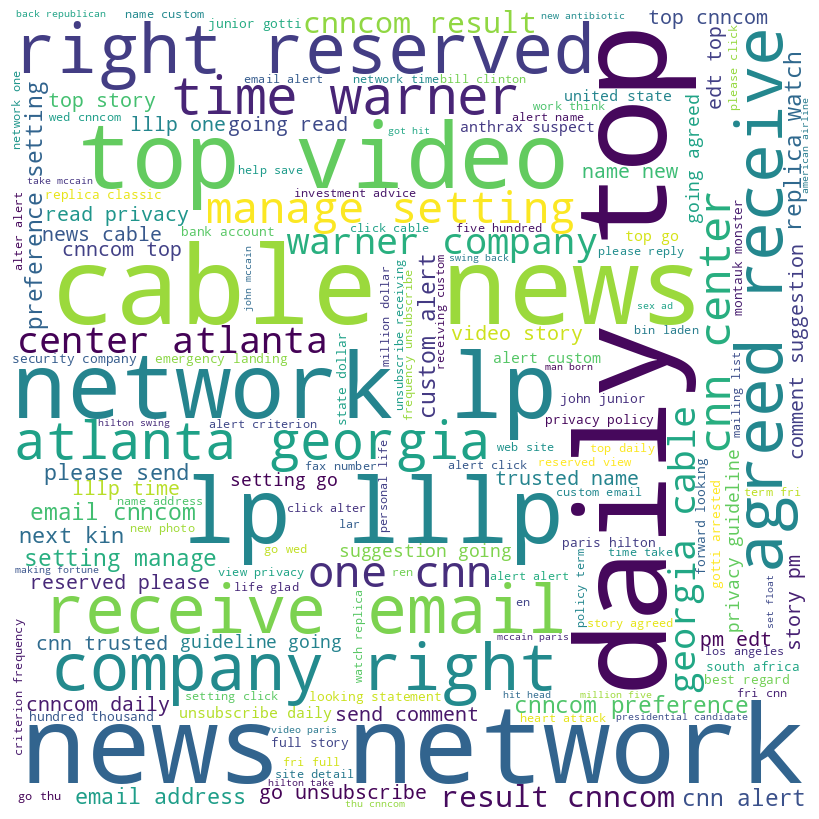

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter out the spam emails
spam_text = data[data['label'] == 1]['text']

# Combine all spam text into a single string
all_spam_text = ' '.join(spam_text)

# Remove meaningless words or symbols (length=1)
filtered_spam_words = [word for word in all_spam_text.split() if len(word) > 1 and word != 'aug']

# Join the filtered words back into a single string
filtered_spam_text = ' '.join(filtered_spam_words)

# Generate the word cloud
wordcloud_spam = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(filtered_spam_text)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_spam)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

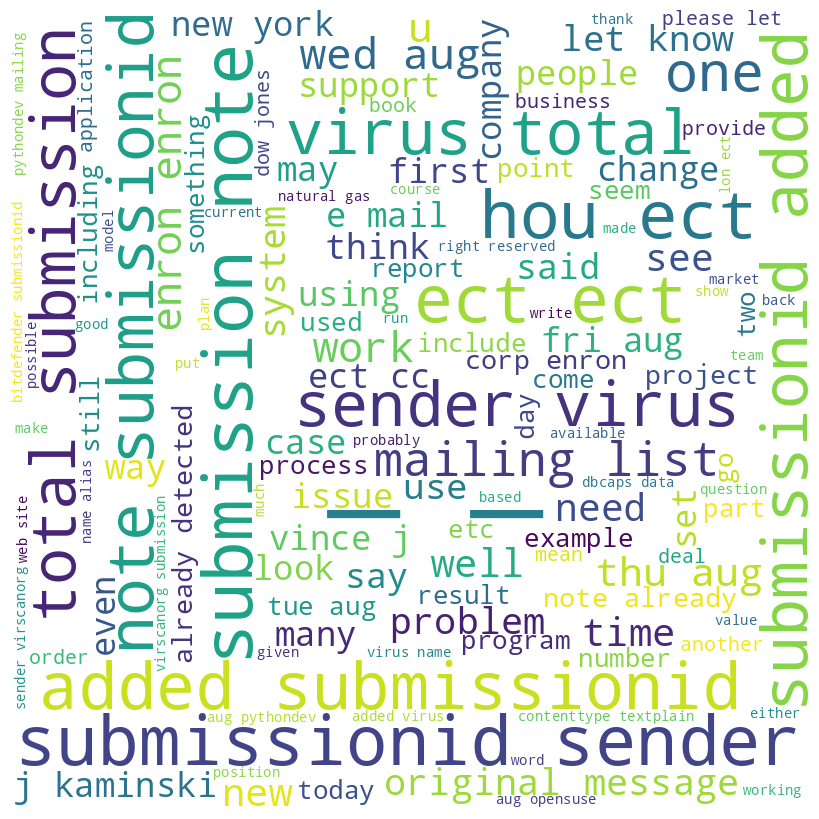

In [7]:
# Filter out the ham emails
ham_text = data[data['label'] == 0]['text']

# Combine all ham text into a single string
all_ham_text = ' '.join(ham_text)

# Remove meaningless words or symbols (length=1)
filtered_ham_words = [word for word in all_ham_text.split() if len(word) > 1 and word != 'aug']

# Join the filtered words back into a single string
filtered_ham_text = ' '.join(filtered_ham_words)

# Generate the word cloud
wordcloud_ham = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_ham_text)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_ham)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

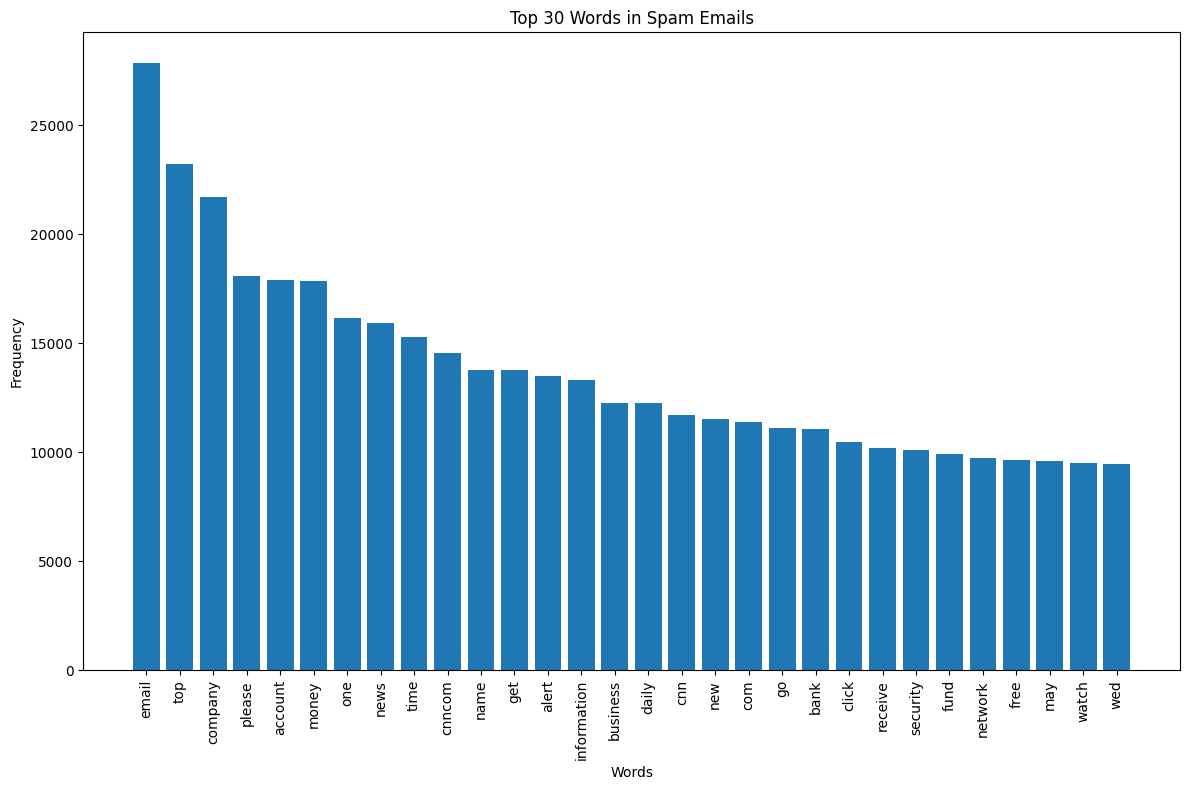

In [8]:
from collections import Counter

# Count the frequency of each word
word_counts = Counter(filtered_spam_words)

# Get the top 30 most common words
top_words = word_counts.most_common(30)

# Separate words and their counts for plotting
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words in Spam Emails')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

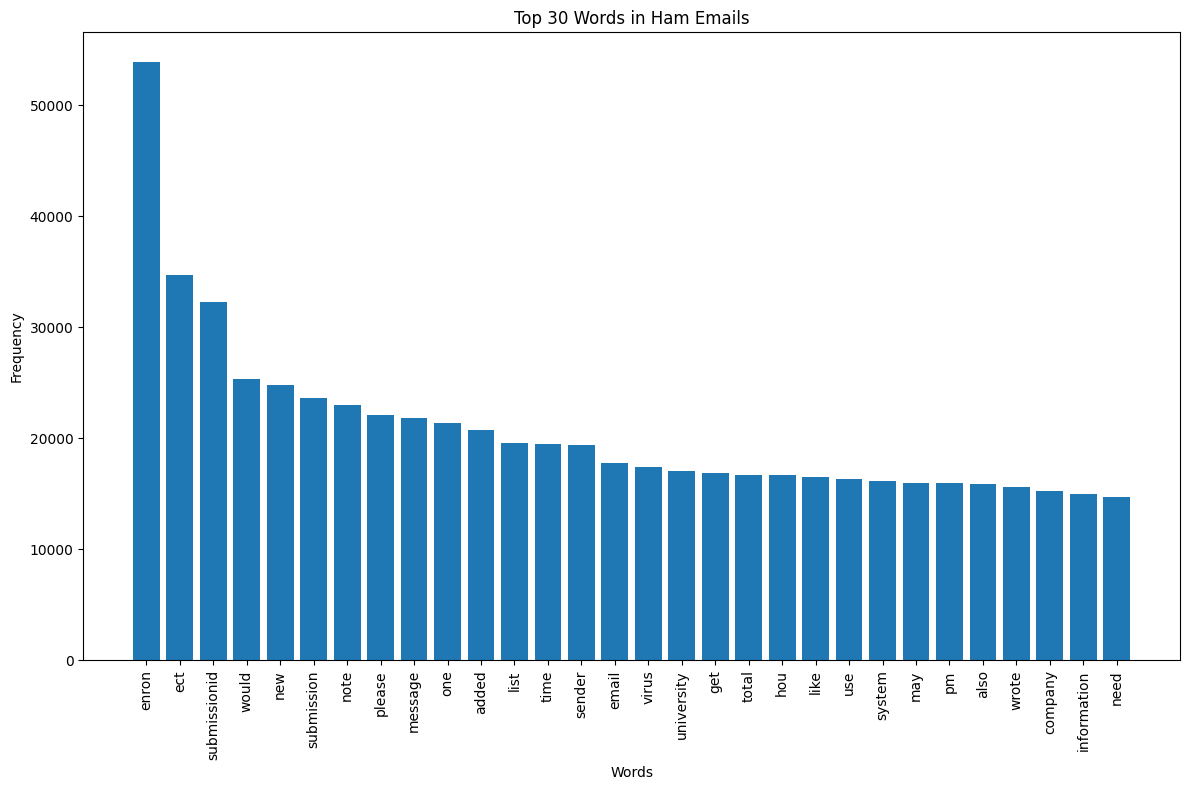

In [9]:
# Count the frequency of each word
word_counts = Counter(filtered_ham_words)

# Get the top 30 most common words
top_words = word_counts.most_common(30)

# Separate words and their counts for plotting
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words in Ham Emails')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [10]:
# Using 10% of the data as a final test set and applying k-fold validation on the remaining 90%

from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# Split data into 90% for cross-validation and 10% for final test set
X = data['text']
y = data['label']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Apply k-fold validation on the remaining 90%
n_splits = 5  # You can adjust the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Print the sizes of the splits for demonstration
print("K-Fold Split Sizes:")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_full)):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    print(f"Fold {fold+1}:")
    print(f"  Training set size: {len(X_train)}")
    print(f"  Validation set size: {len(X_val)}")

# The final test set (X_test, y_test) is held out until the end for final evaluation
print("\nFinal test set size:")
print(f"  Test set size: {len(X_test)}")

K-Fold Split Sizes:
Fold 1:
  Training set size: 59389
  Validation set size: 14848
Fold 2:
  Training set size: 59389
  Validation set size: 14848
Fold 3:
  Training set size: 59390
  Validation set size: 14847
Fold 4:
  Training set size: 59390
  Validation set size: 14847
Fold 5:
  Training set size: 59390
  Validation set size: 14847

Final test set size:
  Test set size: 8249


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Adjust max_features as needed

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fold_times = []

# Run Gradient Boosting Machine model for each fold
print("\nRunning Gradient Boosting Machine for each fold:")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_full)):
    start_time = time.time()

    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    # Fit and transform the training data, transform the validation data
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)

    # Initialize and train the Gradient Boosting Machine model
    gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Adjust parameters as needed
    gbm_model.fit(X_train_tfidf, y_train)

    # Predict on the validation set
    y_pred = gbm_model.predict(X_val_tfidf)

    # Evaluate the model
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    end_time = time.time()
    fold_time = end_time - start_time
    fold_times.append(fold_time)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Fold {fold+1} completed in {fold_time:.2f} seconds.")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Confusion Matrix:\n{cm}")
    print("-" * 30)

# Calculate and print average metrics across all folds
print("\nAverage Metrics Across All Folds:")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average Fold Time: {np.mean(fold_times):.2f} seconds")


Running Gradient Boosting Machine for each fold:
Fold 1 completed in 276.84 seconds.
  Accuracy: 0.9396
  Precision: 0.9197
  Recall: 0.9688
  F1 Score: 0.9436
  Confusion Matrix:
[[6447  655]
 [ 242 7504]]
------------------------------
Fold 2 completed in 272.90 seconds.
  Accuracy: 0.9405
  Precision: 0.9195
  Recall: 0.9698
  F1 Score: 0.9440
  Confusion Matrix:
[[6516  652]
 [ 232 7448]]
------------------------------
Fold 3 completed in 278.57 seconds.
  Accuracy: 0.9441
  Precision: 0.9253
  Recall: 0.9714
  F1 Score: 0.9478
  Confusion Matrix:
[[6486  608]
 [ 222 7531]]
------------------------------
Fold 4 completed in 298.15 seconds.
  Accuracy: 0.9434
  Precision: 0.9220
  Recall: 0.9721
  F1 Score: 0.9464
  Confusion Matrix:
[[6580  628]
 [ 213 7426]]
------------------------------
Fold 5 completed in 275.80 seconds.
  Accuracy: 0.9403
  Precision: 0.9228
  Recall: 0.9671
  F1 Score: 0.9444
  Confusion Matrix:
[[6433  630]
 [ 256 7528]]
------------------------------

Aver

In [20]:
# The model for the final test set would be trained on the entire X_train_full and y_train_full and then evaluated on X_test and y_test
X_train_full_tfidf = tfidf_vectorizer.fit_transform(X_train_full)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
final_gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
final_gbm_model.fit(X_train_full_tfidf, y_train_full)
y_test_pred = final_gbm_model.predict(X_test_tfidf)
final_accuracy = accuracy_score(y_test, y_test_pred)
final_precision = precision_score(y_val, y_pred)
final_recall = recall_score(y_val, y_pred)
print(f"\nFinal Test Set Accuracy: {final_accuracy:.4f}")
print(f"\nFinal Test Set Precision: {final_precision:.4f}")
print(f"\nFinal Test Set Recall: {final_recall:.4f}")
# Accuracy = (TP + TF) / (Total Number) Out of entire dataset, percentage of Correctly Predicted Values
# Precision = TP / (TP + FP) Out of all True Predictions, percentage of actuall True
# Recall = TP / (TP + FN) Out of all Actual True values, percentage of True Prediction


Final Test Set Accuracy: 0.9398

Final Test Set Precision: 0.9228

Final Test Set Recall: 0.9671


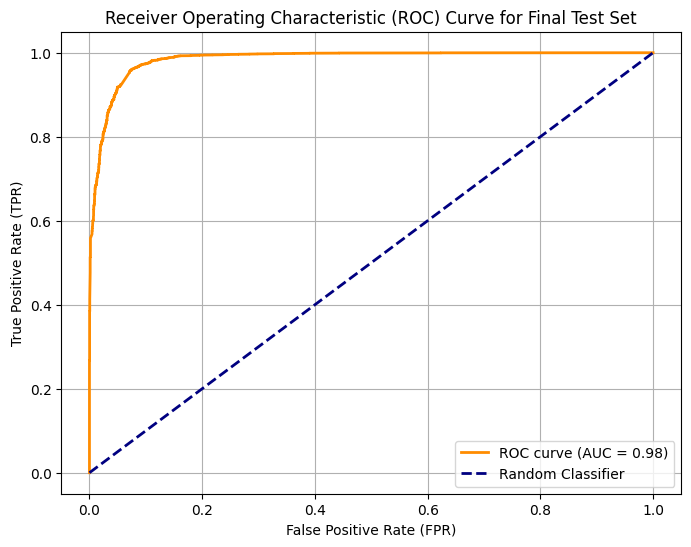

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (label 1)
y_test_prob = final_gbm_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate the ROC curve points (FPR and TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Final Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [17]:
# Print the Confusion Matrix to check the result before plotting out
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3579  381]
 [ 116 4173]]


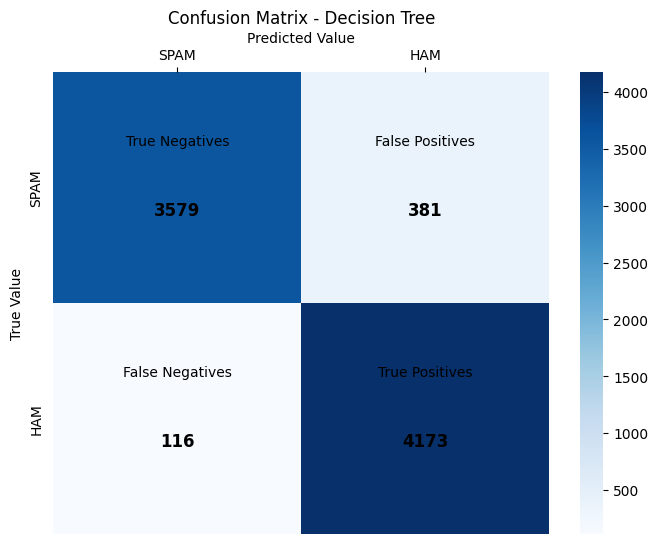

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Plot the confusion matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(8, 6)) # Create figure and axes
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=['SPAM', 'HAM'], yticklabels=['SPAM', 'HAM'], ax=ax) # Pass ax to heatmap

# Add custom annotations
labels = np.array([['True Negatives', 'False Positives'],
                   ['False Negatives', 'True Positives']])

# Get the center positions for the annotations
# The positions are slightly adjusted to be above the numbers
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.3, labels[i, j],
                 ha="center", va="center", color="black", fontsize=10)
        plt.text(j + 0.5, i + 0.6, cm[i, j],
                 ha="center", va="center", color="black", fontsize=12, fontweight='bold')

plt.xlabel('Predicted Value')
plt.ylabel('True Value') # Keep ylabel for clarity below the matrix
plt.title('Confusion Matrix - Decision Tree') # Update title

# Move yticklabels to the right and position xlabel at the top
ax.tick_params(left=False, labelleft=True, right=False, labelright=False,
               top=True, labeltop=True, bottom=False, labelbottom=False)

ax.xaxis.set_label_position('top') # Move xlabel to the top
ax.yaxis.set_label_position('left') # Ensure ylabel remains on the left (default)

plt.show()